In [1]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import glob
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates, collections
from matplotlib import cm
from matplotlib import patches

from shapely import geometry

from stompy import utils, memoize, filters,xr_utils, xr_transect
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
import stompy.plot.cmap as scmap
from stompy.model.fish_ptm import ptm_tools

from stompy.spatial import field, proj_utils, wkb2shp
from stompy.model import data_comparison
%matplotlib notebook
turbo=scmap.load_gradient('turbo.cpt')

In [2]:
# dem=field.GdalGrid("../../bathy/junction-composite-20190117-no_adcp.tif")
dem=field.GdalGrid("../../bathy/junction-composite-20200604-w_smooth.tif")

Velocity overview figure
---

In [3]:
adcp_transects=wkb2shp.shp2geom("../../gis/model_transects.shp")

trans=[t['name'].startswith('2018') for t in adcp_transects]

sel_adcp_transects=adcp_transects[trans]

In [4]:
# zoom=(647100., 647456., 4185649., 4185974.)
zoom=(647066, 647547., 4185592., 4185997.)
demc=dem.crop([647000,647550,4.185550e6,4.186070e6])

cmap=turbo
#cmap=cm.plasma_r

In [5]:
aerial=field.GdalGrid('../../gis/aerial/m_3712114_sw_10_h_20160621_20161004-UTM-crop.tif',
                     geo_bounds=zoom)
aerial.F=aerial.F[:,:,:3] # drop alpha - seems mis-scaled


Putting multiple channels as last index


Streamline Tracer Approach
--

In [6]:
def prep_model_data(avg_nc,t_idx):
    avg_snap=avg_nc.isel(time=t_idx)
    g=unstructured_grid.UnstructuredGrid.read_ugrid(avg_snap)
    c2e=g.cells['edges']
    c2e[ c2e==999999 ] = -1
    
    # Vertical integration on the average output:
    from stompy.grid import ugrid
    ug=ugrid.UgridXr(avg_nc,face_eta_vname='eta')
    for v in ['dv','z_r','z_w']:
        avg_nc[v].attrs['positive']='down'
    # had been depth average, with zbottom=0
    weights=ug.vertical_averaging_weights(time_slice=t_idx,ztop=0,dz=2)
    U=avg_nc.uc.isel(time=t_idx).values.T
    V=avg_nc.vc.isel(time=t_idx).values.T
    Udavg=np.nansum( U * weights, axis=1)
    Vdavg=np.nansum( V * weights, axis=1)

    Uc=np.c_[ Udavg, Vdavg]
    return g,Uc


In [7]:
from stompy.grid import exact_delaunay
from stompy.model import stream_tracer
six.moves.reload_module(unstructured_grid)
six.moves.reload_module(exact_delaunay)
six.moves.reload_module(stream_tracer)

<module 'stompy.model.stream_tracer' from '/home/rustyh/src/stompy/stompy/model/stream_tracer.py'>

In [8]:
from stompy.plot import stream_quiver
six.moves.reload_module(stream_quiver)

<module 'stompy.plot.stream_quiver' from '/home/rustyh/src/stompy/stompy/plot/stream_quiver.py'>

In [9]:
# Go back to real data:
# model=sun_driver.SuntansModel.load('runs/short045_g8.24_20180405')
# What a pain.. avg_nc has cell-center velocities already calculated,
# while ptm_avg has volumes already calculated.

# min_clearance=2 was too close..
# 4,8 was close, but left a few short ones...

kws=dict(min_clearance=4,
         seed_clearance=8,
         max_t=40.,
         max_dist=60.,
         pack=True)

# Late, high flow run:
avg_fn='runs/cfg012_farm12_20180330/average.nc_0000.nc'
avg_nc=xr.open_dataset(avg_fn)
t_idx = np.searchsorted( avg_nc.time.values, np.datetime64('2018-04-05T16:00'))

g,Uc=prep_model_data(avg_nc,t_idx)
sq_highflow=stream_quiver.StreamlineQuiver(g,Uc,streamline_count=1500,**kws)

# Earlier run
avg_fn="runs/cfg012_farm12_20180310/average.nc_0000.nc"
avg_nc=xr.open_dataset(avg_fn)
t_idx=414 # 1656 # trying to find a nice flood. This probably has to get updated.
g,Uc=prep_model_data(avg_nc,t_idx)
sq_flood=stream_quiver.StreamlineQuiver(g,Uc,streamline_count=1500,**kws)

INFO:join_features:0 open strings, 1 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=152841.432267, 0 potential interiors


***********************

/home/rustyh/src/stompy/stompy/grid/unstructured_grid.py:2514: RuntimeWarning: divide by zero encountered in true_divide
  cxy[valid] /= 6*A[valid,None]


*************************************************************************************************************************************************************************************************************************-**************************************-**-********-*******-******************-**-***************-****-*-*-********-*******-**********-*****-***-**-***-**-****.**-*-****-***-**-**-**-****-****-********-**-*-*-**-*-******-*-*-*-*-*-*-*-*.**-****-*-*-*-**-*-*****-*-**-**-*-**-*-*-*-*-******-*-****Stopping on seed clearance


INFO:join_features:0 open strings, 1 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=152841.432267, 0 potential interiors


********************

/home/rustyh/src/stompy/stompy/grid/unstructured_grid.py:2514: RuntimeWarning: divide by zero encountered in true_divide
  cxy[valid] /= 6*A[valid,None]


******************************************************************************************************************************************************************************************************************************************************************************.**********************************************************************************************************************************************************-*******************-******************-*********************************************************************.**********************************************************************************-***-****-********************-*.**-*-*-*******.*****.***********-**********************-***********-****-*.***-**.****.*******-*****-**-****-*-**.****-***-*****-****-***.*-****-**-**-***********-***-*********.***-*****-**-***-***-**********-****-**Stopping on seed clearance


In [11]:
clim

[0, 1.5]

<IPython.core.display.Javascript object>


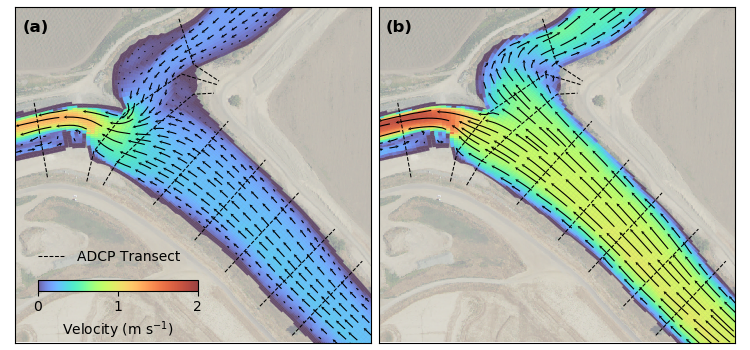

In [14]:
#clim=sq_highflow.clim
clim=[0,2]
# Shift some contrast to the lower end
cmap=scmap.cmap_transform(turbo,lambda x: x**0.75)

fade=0.75
cmap=scmap.transform_color(lambda x: fade*x + (1-fade), cmap)

class QuiverPlotWithBackground(object):
    bathy_contour=False
    legend=True
    cbar=True
    
    ax=None
    dV=1.0 # interval for contours
    sq=None # Stream quiver instance
    include_truncated=False

    zoom=(647076.5624255964, 647510.026008116, 4185590.120652568, 4185998.7323230235)

    cax_rel=[0.03,0.15,0.45,0.03]
    leg_loc=[0.048,0.22]

    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        if self.ax is None:
            self.ax=plt.gca()
        self.plot()
    def add_bathy_contour(self):
        demc.contour(np.arange(-10,6,self.dV),ax=self.ax,
                     cmap='gray_r',linewidths=0.2,
                     zorder=-1)

    def fmt_axes(self):
        ax=self.ax
        ax.set_adjustable('datalim')
        ax.axis('equal')
        ax.yaxis.set_visible(0)
        ax.xaxis.set_visible(0)

    def plot(self):
        self.fmt_axes()
        if self.bathy_contour:
            self.add_bathy_contour()
        self.quiver=self.sq.plot_quiver(ax=self.ax,include_truncated=self.include_truncated)
        self.plot_adcp()
        self.adjust_quiver(self.quiver)
        self.plot_speed()
        self.plot_aerial()
        self.ax.axis(self.zoom)

    def plot_adcp(self):
        # And show the ADCP transect locations, too.
        for t in sel_adcp_transects:
            name=int(t['name'].replace('2018_',''))
            xy=np.array(t['geom'])
            l=self.ax.plot(xy[:,0],xy[:,1],color='k',ls='--',lw=0.75)
            plot_utils.annotate_line(l[0],name,ax=self.ax,norm_position=0.0,rotation=None,
                                    offset_points=5)
        if self.legend:
            self.ax.legend([l[0]],["ADCP Transect"],
                           loc=self.leg_loc,frameon=0)
    def adjust_quiver(self,quiver):
        # black arrows, color in background for speed
        for coll in [quiver['lcoll'],
                     quiver['pcoll']]:
            coll.set_array(None)
            coll.set_color('k')

    def plot_speed(self):
        ccoll=self.sq.g.plot_cells(values=self.sq.Umag,cmap=cmap,clim=clim,ax=self.ax,zorder=-2)
        ccoll.set_edgecolor('face')
        ccoll.set_lw(0.2)
        if self.cbar:
            box=self.ax.get_position()
            self.cax=fig.add_axes([box.xmin+self.cax_rel[0],
                                   box.ymin+self.cax_rel[1],
                                   box.width*self.cax_rel[2], 
                                   box.height*self.cax_rel[3]])
            plt.colorbar(ccoll,cax=self.cax,label='Velocity (m s$^{-1}$)',orientation='horizontal')
    def plot_aerial(self):
        # add aerial image in backgroud
        aerial.plot(ax=self.ax,zorder=-3,alpha=0.5)

        
fig,axs=plt.subplots(1,2,figsize=[7.5, 3.5])
fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02,wspace=0.02)

q1=QuiverPlotWithBackground(ax=axs[0],sq=sq_flood)
q2=QuiverPlotWithBackground(ax=axs[1],sq=sq_highflow,legend=False,cbar=False)

for ax,lab in zip(axs,"ab"): 
    ax.texts=[]
    ax.text(0.02,0.96,"("+lab+")",va='top',transform=ax.transAxes,fontweight='bold',fontsize=12)

fig.savefig('velocity-overview-panels.png',dpi=200)